### Aplicación de propensity score matching



In [1]:
##Borrar datos del entorno
rm(list=ls())

In [2]:
#Directorio de trabajo
setwd("C:/Users/claud/Documents/GitHub/proyecto_simi")

In [3]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,MatchIt,cobalt)

Loading required package: pacman



#### 1. Se crea función para realizar el modelo y el matching

In [4]:
propscorematch <- function(var_modelo, link_model) {
  # Función para imprimir texto en negritas y mayúsculas
    bold_text <- function(text) paste0("\033[1m", "=== ", toupper(text), " ===", "\033[0m")

  # Modelo GLM
  modelo_glm <- glm(var_modelo, data = datos_colonias, family = link_model)
  
  # Impresión de resultados
  model_type <- ifelse(link_model$link == "logit", "Logit", 
                       ifelse(link_model$link == "probit", "Probit", link_model$link))
  cat(bold_text(paste("Resultados del modelo", model_type, ":")), "\n")
  summary_glm <- summary(modelo_glm)
  print(summary_glm)
  
  # Generación de scores de propensión
  prs_df <- data.frame(pr_score = predict(modelo_glm, type = "response"),
                       simi = datos_colonias$simi)
  
  # MatchIt
  matchit_out <- matchit(var_modelo, data = datos_colonias, method = "nearest", distance = prs_df$pr_score)
  
  # Impresión de resultados de MatchIt
  cat(bold_text("Resumen de los resultados de MatchIt:"), "\n")
  summary_matchit <- summary(matchit_out)
  print(summary_matchit)
  
  # Datos matcheados
  datos_matcheados <- match.data(matchit_out)
  
  # Imprimiendo resultados
  cat(bold_text("Número de manzanas matcheadas:"), nrow(datos_matcheados), "\n")
  cat(bold_text("Número de manzanas matcheadas sin considerar Lomas de San Carlos:"), 
      nrow(datos_matcheados[datos_matcheados$simi == 0, ]), "\n")
  
  # Plot MatchIt
  matchit_plot <- plot(summary_matchit)
  
  # Definición de grupos para el t-test
  group_0 <- "Grupo de control (simi = 0)"
  group_1 <- "Grupo de tratamiento (simi = 1)"
  
  # Impresión del encabezado de los resultados del t-test
  cat(bold_text("Average Treatment Effect among the Treated (ATT):"), "\n")
  cat(bold_text("Grupo 0:"), group_0, "\n")
  cat(bold_text("Grupo 1:"), group_1, "\n")
  
  # T-test
  cat(bold_text("Resultados de la prueba t:"), "\n")
  t_test_result <- t.test(imn_2020 ~ simi, data = datos_matcheados)
  print(t_test_result)
}

#### 2. Se cargan los datos tanto de la colonia Simi como de las colonias "similares" y 
Se crea una dummy para identificar a qué grupo pertenece cada observación. Estos datos son a nivel manzana y corresponden a 67 colonias, considerando la colonia Lomas de San Carlos. La fuente de información es el Censo de Población y Vivienda 2020.

In [5]:
#Cargar datos
datos_colonias<-openxlsx::read.xlsx("G:/Mi unidad/proyecto_simi/indicadores_mza_col.xlsx",sheet=2)%>%
#Crea dummy para identificar si la manzana pertenece a colonia simi o no
mutate(simi=case_when(colonia=="Lomas de San Carlos" ~ 1,
                        TRUE ~ 0))
str(datos_colonias)

'data.frame':	2904 obs. of  39 variables:
 $ cvegeo         : chr  "0900500010258020" "0900500010258035" "0900500010258009" "0900500012574009" ...
 $ cve_col        : chr  "09005_0019" "09005_0019" "09005_0019" "09005_0019" ...
 $ id_col         : num  17240 17240 17240 17240 17240 ...
 $ colonia        : chr  "Benito Juarez" "Benito Juarez" "Benito Juarez" "Benito Juarez" ...
 $ cve_ent        : chr  "09" "09" "09" "09" ...
 $ nom_ent        : chr  "Ciudad de México" "Ciudad de México" "Ciudad de México" "Ciudad de México" ...
 $ cve_mun        : chr  "005" "005" "005" "005" ...
 $ nom_mun        : chr  "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" ...
 $ pobtot         : num  141 147 329 260 117 124 185 119 70 129 ...
 $ hogjef_f       : num  30 27 56 31 24 12 32 22 10 9 ...
 $ hogjef_m       : num  20 19 33 37 13 21 16 15 10 29 ...
 $ graproes       : num  8.91 9.19 8.75 8.44 8.34 ...
 $ pea            : num  77 68 155 117 50 58 87 63 39 56 ...
 $ p

In [6]:
#Contar unos y ceros de la dummy
datos_colonias%>%
    count(simi)

simi,n
<dbl>,<int>
0,2851
1,53


#### 2. Se utilizan datos de marginación. 
Se busca con ello unir los datos de marginación a nivel colonia con los datos de las manzanas de las colonias seleccionadas. Es importante mencionar que si bien los datos de marginación son a nivel colonia, se asume que, a nivel manzana, son homogéneos. La idea es utilizar el índice de marginación como variable de interés para estimar el efecto del tratamiento.

In [7]:
#Se descargan datos de marginación de CONAPO


url_conapo="http://www.conapo.gob.mx/work/models/CONAPO/Marginacion/Datos_Abiertos/Colonia/IMC_2020.zip"

download.file(url_conapo, destfile = "data/IMC_2020.zip")

unzip("data/IMC_2020.zip", exdir = "data/IMC_2020")


In [8]:
#Se leen los datos y se filtra para CDMX y EdoMex
datos_marginacion<-openxlsx::read.xlsx("data/IMC_2020/IMUC_2020.xlsx",sheet=1, 
                                        startRow = 4)%>%
janitor::clean_names()%>%
filter(cve_ent=="09" | cve_ent=="15")%>%
select(cve_col,imn_2020)

In [9]:
#Se unen los datos de marginación a los de las manzanas de las colonias seleccionadas
datos_colonias<-datos_colonias%>%
left_join(datos_marginacion, by=c("cve_col"="cve_col"))
head(datos_colonias,10)

,cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_sinagua,pct_tinaco,pct_cister,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,imn_2020
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0900500010258020,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,141,30,⋯,0,88.67925,22.641509,79.24528,71.69811,33.96226,32.07547,18.867925,0,0.9519898
2,0900500010258035,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,147,27,⋯,0,97.82609,6.521739,60.86957,47.82609,30.43478,21.73913,15.217391,0,0.9519898
3,0900500010258009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,329,56,⋯,0,78.26087,18.478261,80.43478,59.78261,33.69565,34.78261,22.826087,0,0.9519898
4,0900500012574009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,260,31,⋯,0,74.64789,14.084507,84.50704,50.70423,39.43662,21.12676,8.450704,0,0.9519898
5,0900500010258019,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,117,24,⋯,0,92.10526,0.000000,57.89474,57.89474,31.57895,10.52632,0.000000,0,0.9519898
6,0900500012574010,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,124,12,⋯,0,83.33333,25.000000,77.77778,58.33333,38.88889,41.66667,13.888889,0,0.9519898
7,0900500010258001,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,185,32,⋯,0,84.00000,28.000000,88.00000,58.00000,44.00000,46.00000,24.000000,0,0.9519898
8,0900500010258045,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,119,22,⋯,0,92.50000,0.000000,65.00000,62.50000,30.00000,32.50000,15.000000,0,0.9519898
9,0900500010258002,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,70,10,⋯,0,95.00000,0.000000,90.00000,45.00000,40.00000,25.00000,0.000000,0,0.9519898


#### 3. Se inspeccionan las variables para ver si es necesario realizar alguna transformación

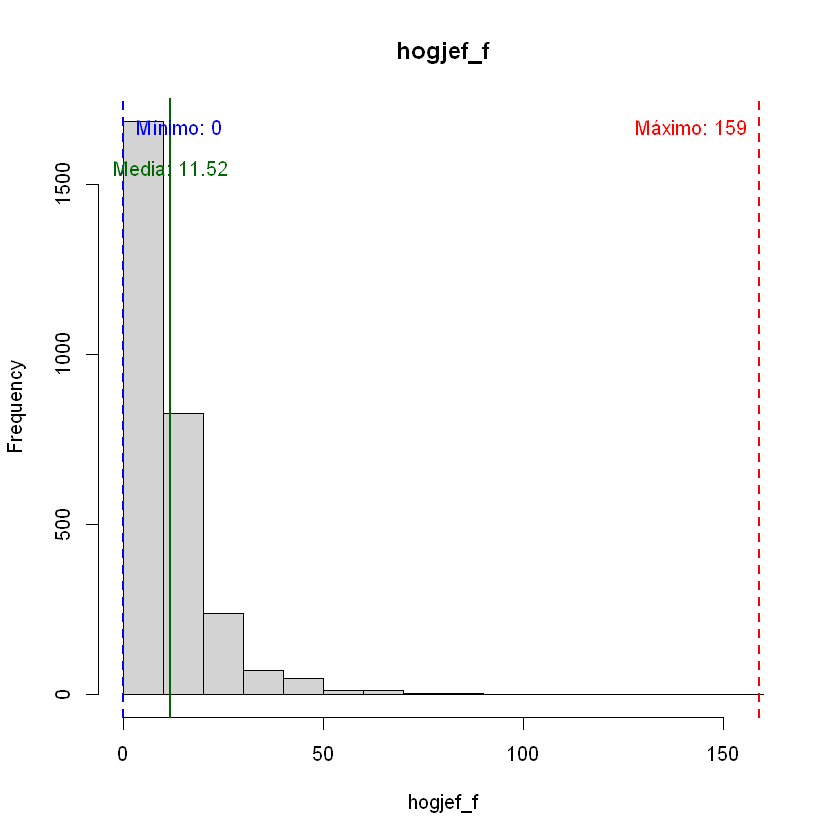

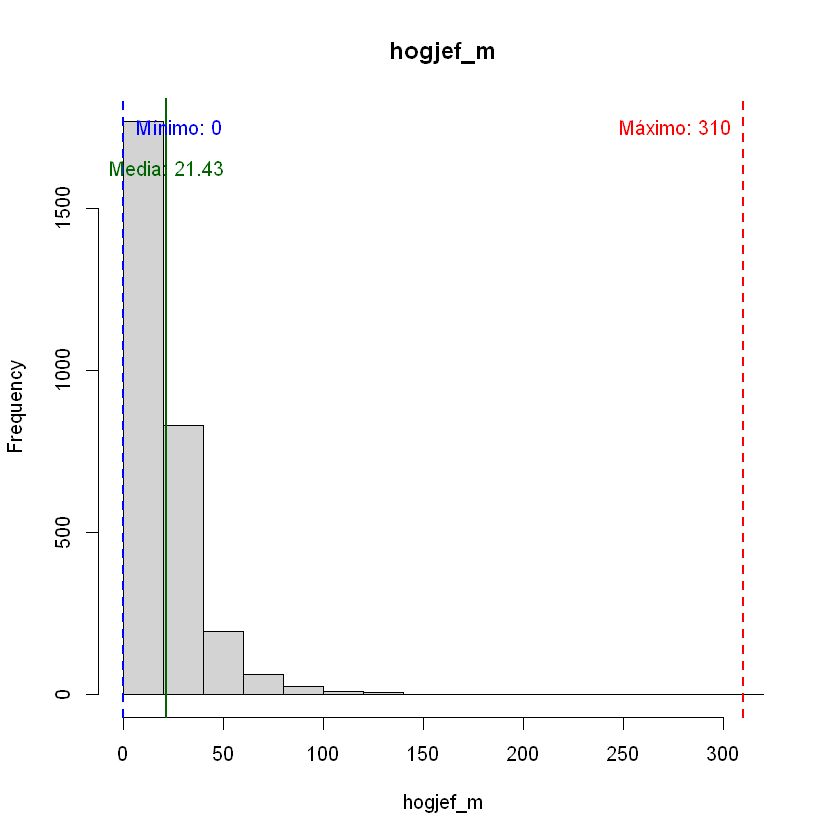

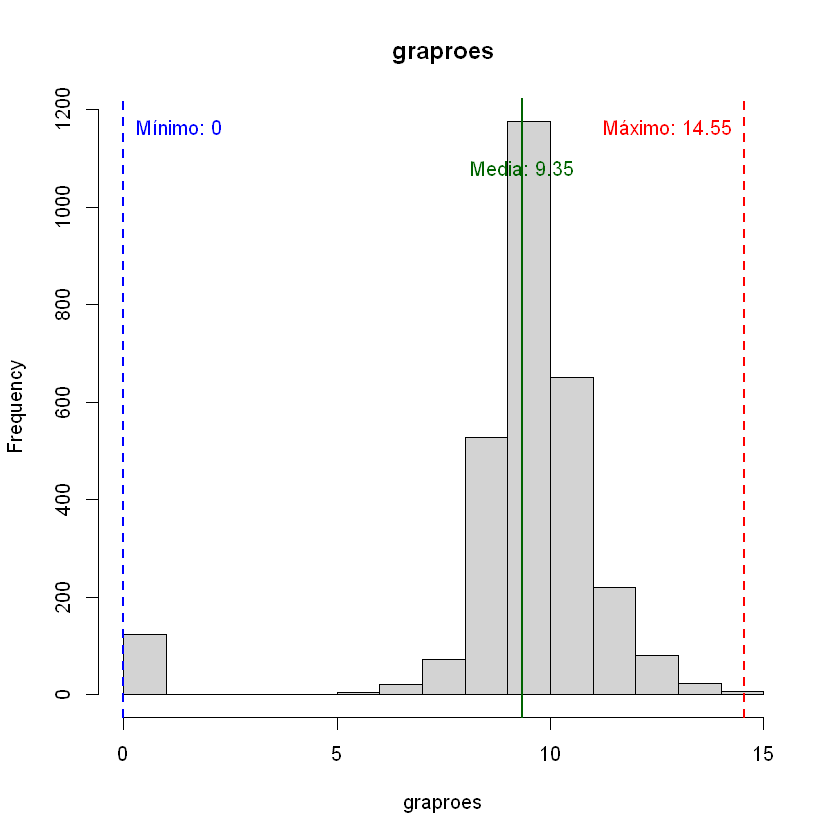

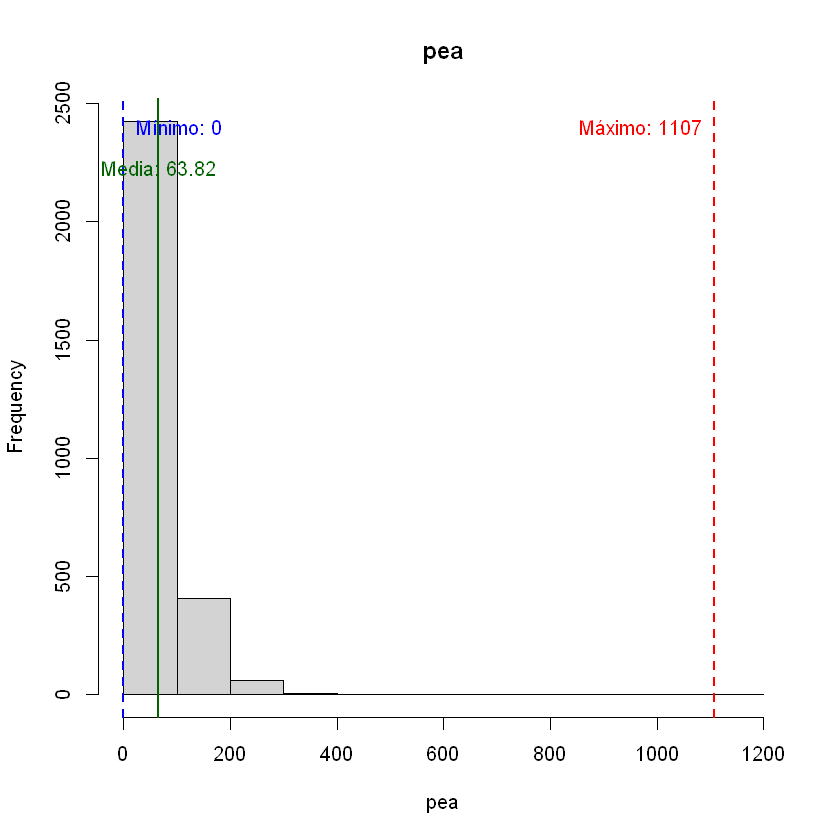

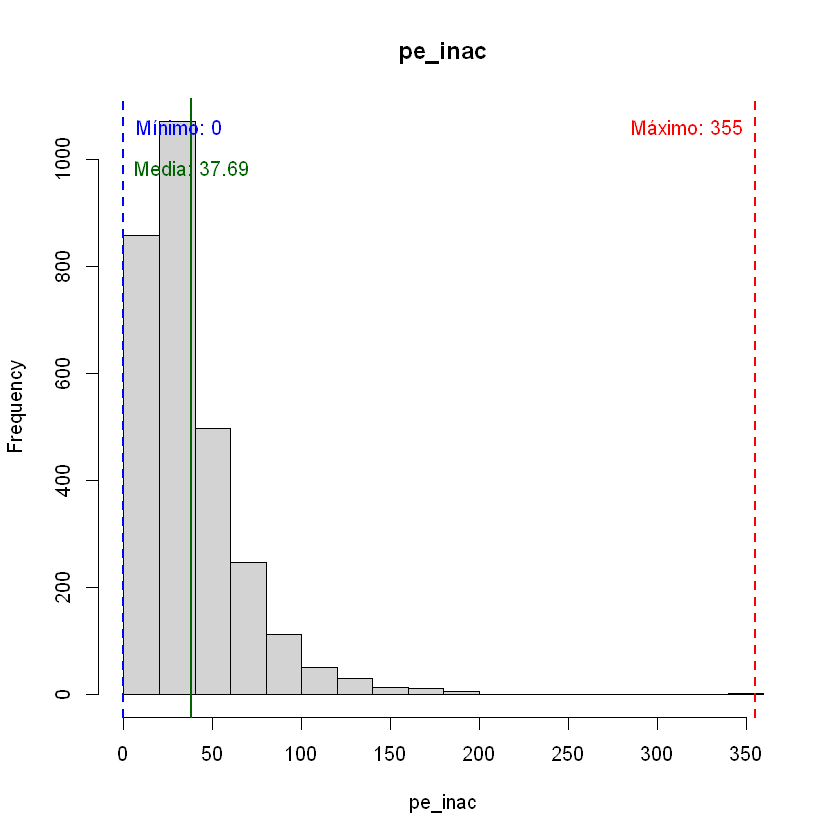

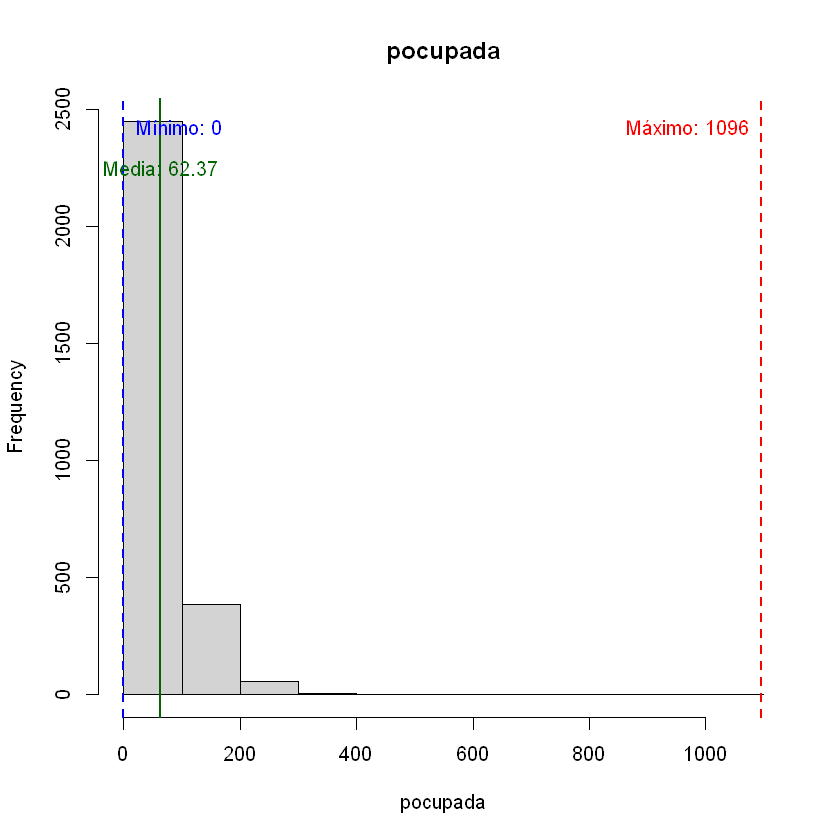

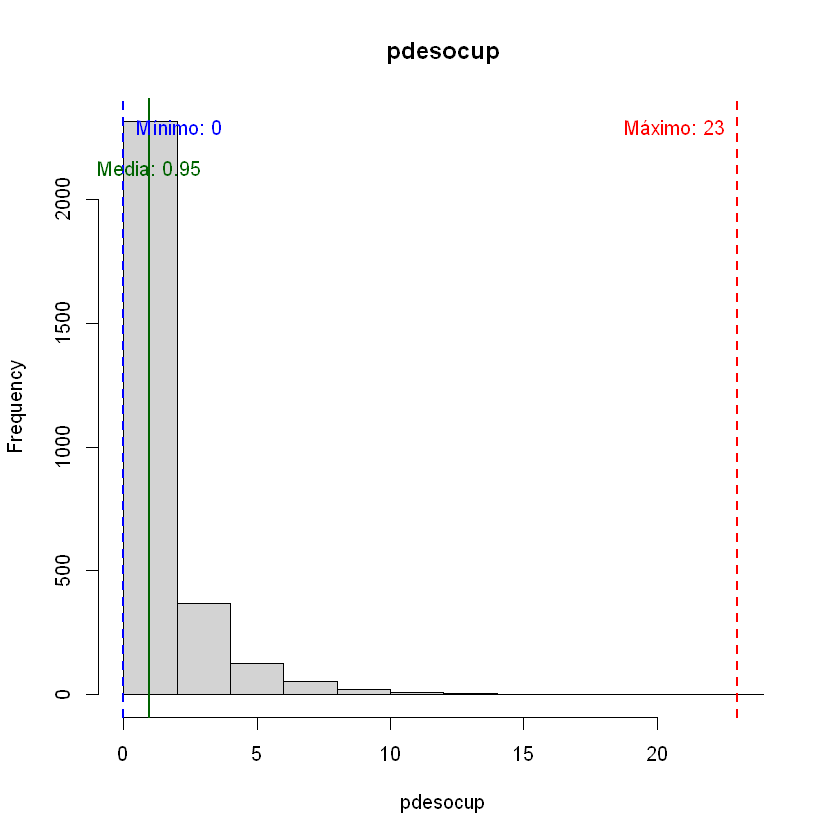

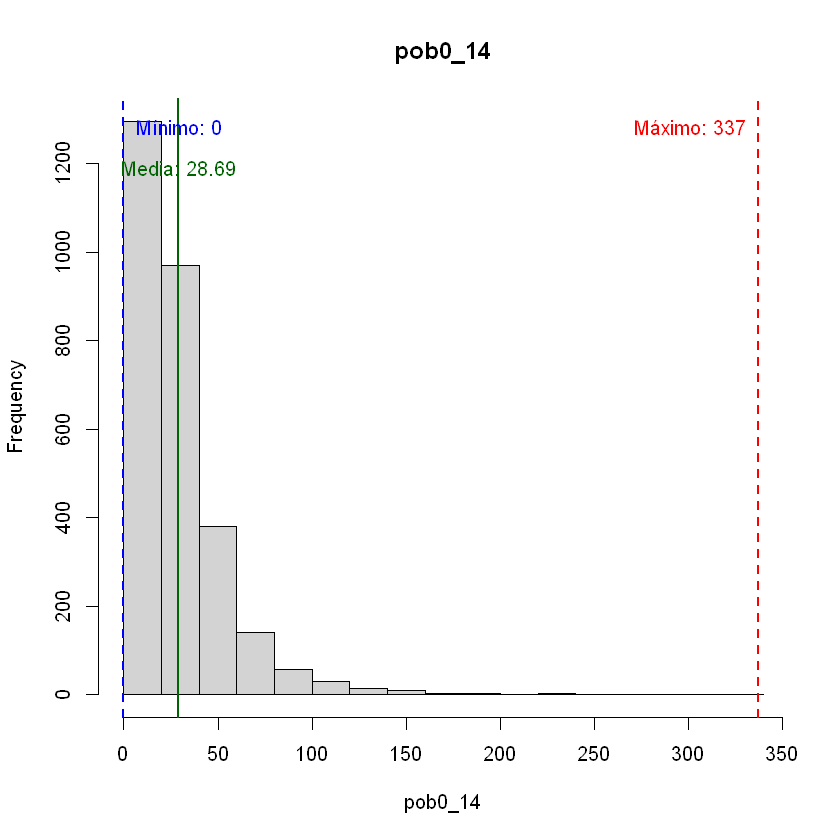

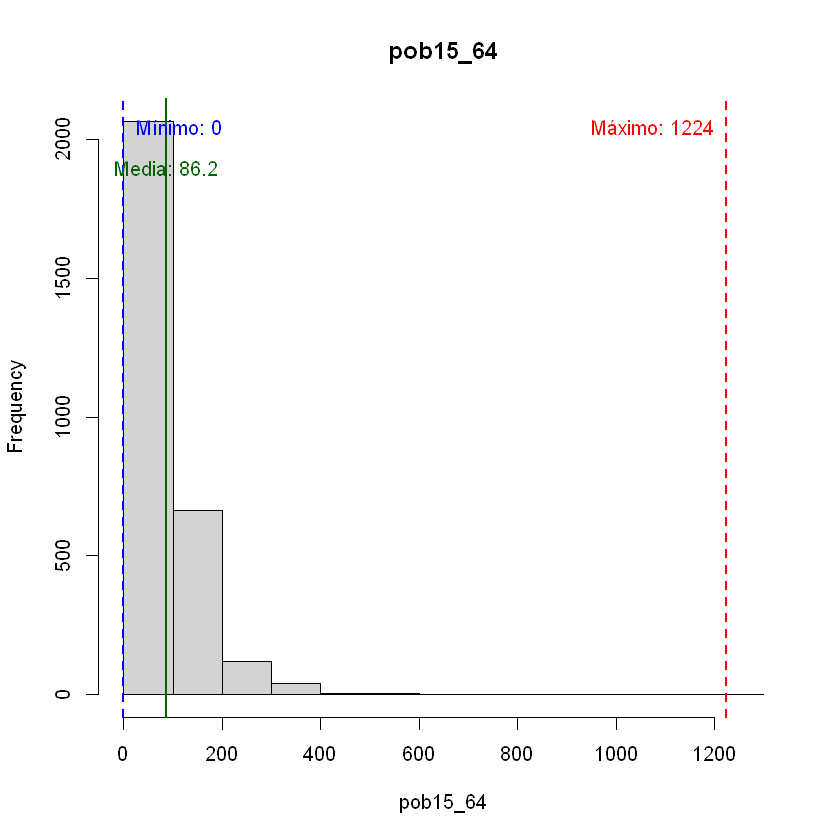

$hogjef_f
NULL

$hogjef_m
NULL

$graproes
NULL

$pea
NULL

$pe_inac
NULL

$pocupada
NULL

$pdesocup
NULL

$pob0_14
NULL

$pob15_64
NULL

$pob65_mas
NULL

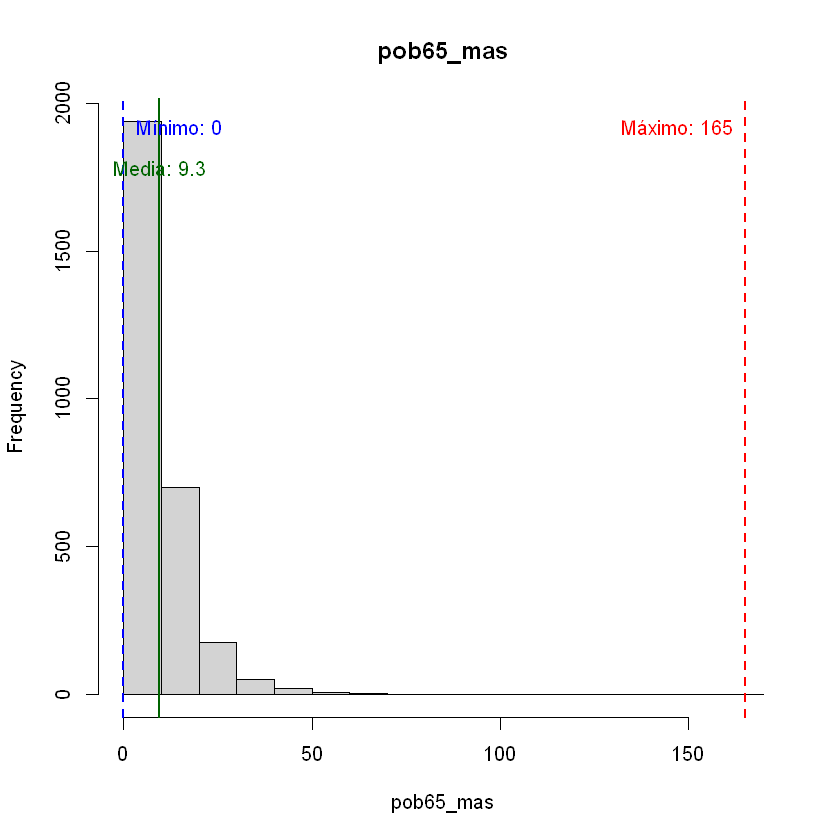

In [10]:

# Inspección de variables
datos_colonias %>%
  select(hogjef_f, hogjef_m, graproes, pea, pe_inac, pocupada, pdesocup, pob0_14, pob15_64, pob65_mas) %>%
  map2(names(.), ~{
    # Calcular máximos, mínimos y medias
    min_val <- min(.x, na.rm = TRUE)
    max_val <- max(.x, na.rm = TRUE)
    mean_val <- mean(.x, na.rm = TRUE)
    
    # Histograma
    hist(.x, main = .y, xlab = .y, col = "lightgray", border = "black")
    
    # Líneas de máximos, mínimos y medias
    abline(v = min_val, col = "blue", lty = 2, lwd = 2)
    abline(v = max_val, col = "red", lty = 2, lwd = 2)
    abline(v = mean_val, col = "darkgreen", lty = 1, lwd = 2)
    
    # Etiquetas
    text(min_val, par("usr")[4] * 0.95, labels = paste("Mínimo:", round(min_val, 2)), col = "blue", pos = 4)
    text(max_val, par("usr")[4] * 0.95, labels = paste("Máximo:", round(max_val, 2)), col = "red", pos = 2)
    text(mean_val, par("usr")[4] * 0.85, labels = paste("Media:", round(mean_val, 2)), col = "darkgreen", pos = 3)
  })


## Modelos
#### 3. Se establecen los modelos a utilizar

In [ ]:
#Modelo general
var_modelo <- simi ~ hogjef_f + hogjef_m + graproes + pea +  
              pe_inac + pocupada + pdesocup + pob0_14 + pob15_64 + pob65_mas

#Modelo con transformación de variables de población a logaritmos. Se utiliza 1 para evitar problemas con ceros
var_modelo2 <- simi ~ log(ifelse(hogjef_f == 0, 1, hogjef_f)) + 
                       log(ifelse(hogjef_m == 0, 1, hogjef_m)) + 
                       graproes + 
                       log(ifelse(pea == 0, 1, pea)) +  
                       log(ifelse(pe_inac == 0, 1, pe_inac)) + 
                       log(ifelse(pocupada == 0, 1, pocupada)) + 
                       log(ifelse(pdesocup == 0, 1, pdesocup)) + 
                       log(ifelse(pob0_14 == 0, 1, pob0_14)) + 
                       log(ifelse(pob15_64 == 0, 1, pob15_64)) + 
                       log(ifelse(pob65_mas == 0, 1, pob65_mas))

#### Modelo probit

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.169468   0.257440  -8.427  < 2e-16 ***
hogjef_f    -0.001087   0.017018  -0.064   0.9491    
hogjef_m     0.025554   0.014405   1.774   0.0761 .  
graproes     0.031545   0.027659   1.141   0.2541    
pea         -0.076610   0.091018  -0.842   0.4000    
pe_inac     -0.042467   0.024924  -1.704   0.0884 .  
pocupada     0.015783   0.086878   0.182   0.8558    
pdesocup    -0.113903   0.090695  -1.256   0.2092    
pob0_14      0.042366   0.010148   4.175 2.98e-05 ***
pob15_64     0.036525   0.025738   1.419   0.1559    
pob65_mas    0.029846   0.026386   1.131   0.2580    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.4  on 2903  degrees of freedom
Residual deviance: 488.1  on 2893  degre

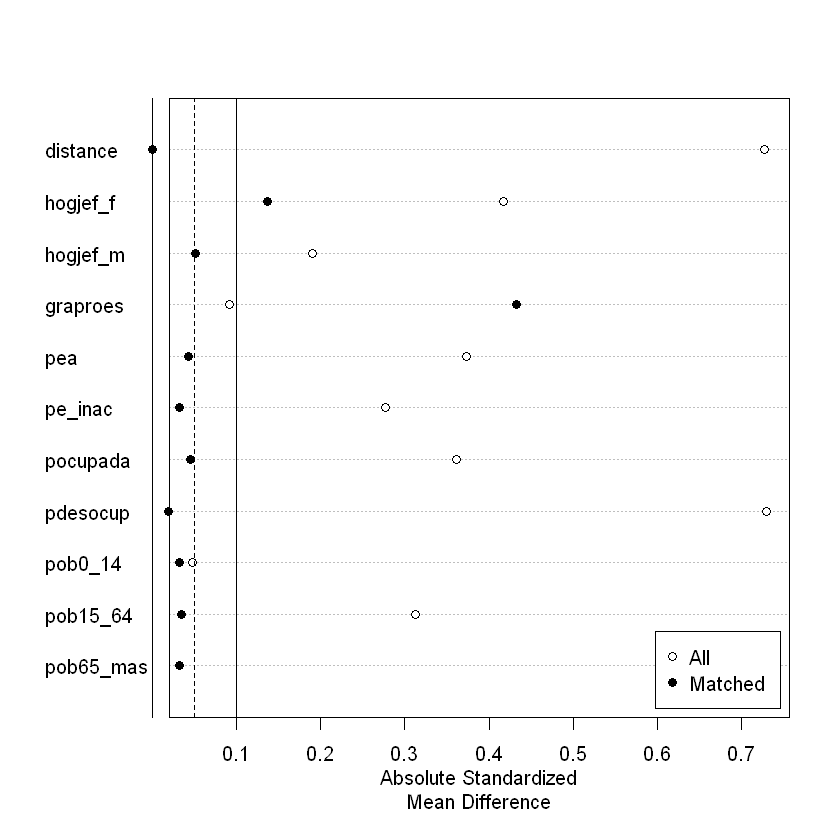

In [12]:
propscorematch(var_modelo = var_modelo, link_model = binomial(link = "probit"))

#### Modelo probit con transformación de variables de población a logaritmos

=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -2.29006    0.30569  -7.491 6.81e-14
log(ifelse(hogjef_f == 0, 1, hogjef_f))   -0.19434    0.11569  -1.680  0.09299
log(ifelse(hogjef_m == 0, 1, hogjef_m))    0.31326    0.24271   1.291  0.19683
graproes                                  -0.03169    0.05001  -0.634  0.52628
log(ifelse(pea == 0, 1, pea))             -4.93426    2.90467  -1.699  0.08937
log(ifelse(pe_inac == 0, 1, pe_inac))     -0.74837    0.25817  -2.899  0.00375
log(ifelse(pocupada == 0, 1, pocupada))    2.75943    2.75840   1.000  0.31713
log(ifelse(pdesocup == 0, 1, pdesocup))   -0.24721    0.17229  -1.435  0.15135
log(ifelse(pob0_14 == 0, 1, pob0_14))      0.50088    0.20334   2.463  0.01377
log(ifelse(pob15_64 == 0, 1, pob15_64))    2.23098    0.74720   2.986  0.00283

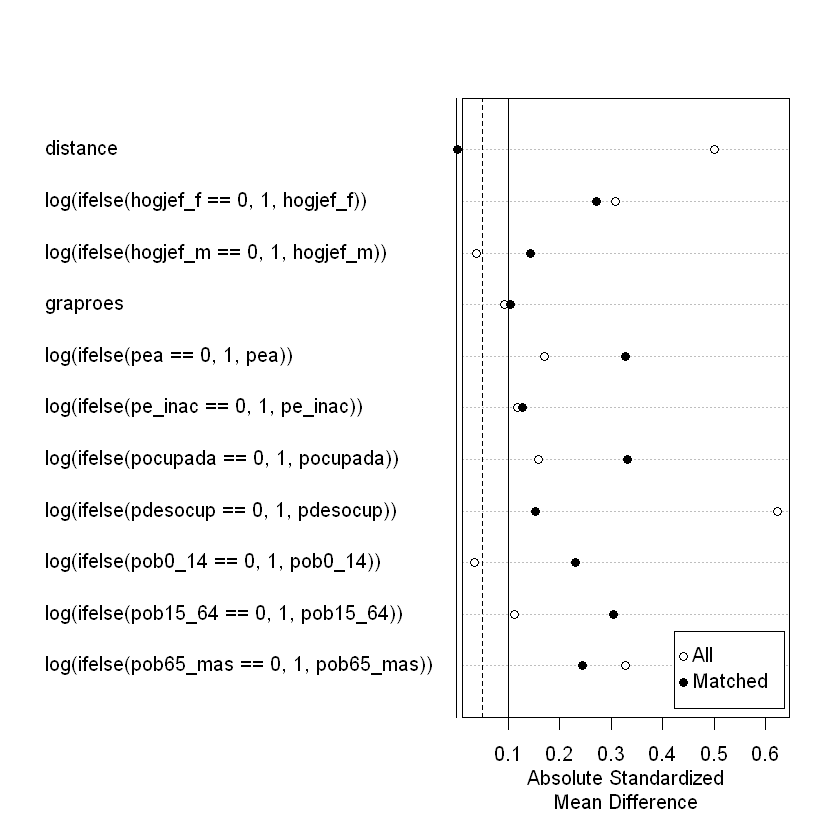

In [13]:
propscorematch(var_modelo = var_modelo2, link_model = binomial(link = "probit"))

#### Modelo logit   

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


=== RESULTADOS DEL MODELO LOGIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.104618   0.631493  -6.500 8.04e-11 ***
hogjef_f    -0.000985   0.041689  -0.024   0.9811    
hogjef_m     0.057572   0.033809   1.703   0.0886 .  
graproes     0.072038   0.067621   1.065   0.2867    
pea         -0.193690   0.218278  -0.887   0.3749    
pe_inac     -0.109612   0.059647  -1.838   0.0661 .  
pocupada     0.040800   0.208319   0.196   0.8447    
pdesocup    -0.277124   0.224704  -1.233   0.2175    
pob0_14      0.097968   0.023327   4.200 2.67e-05 ***
pob15_64     0.097028   0.061757   1.571   0.1162    
pob65_mas    0.075359   0.063004   1.196   0.2317    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 489.35  on 2893  degr

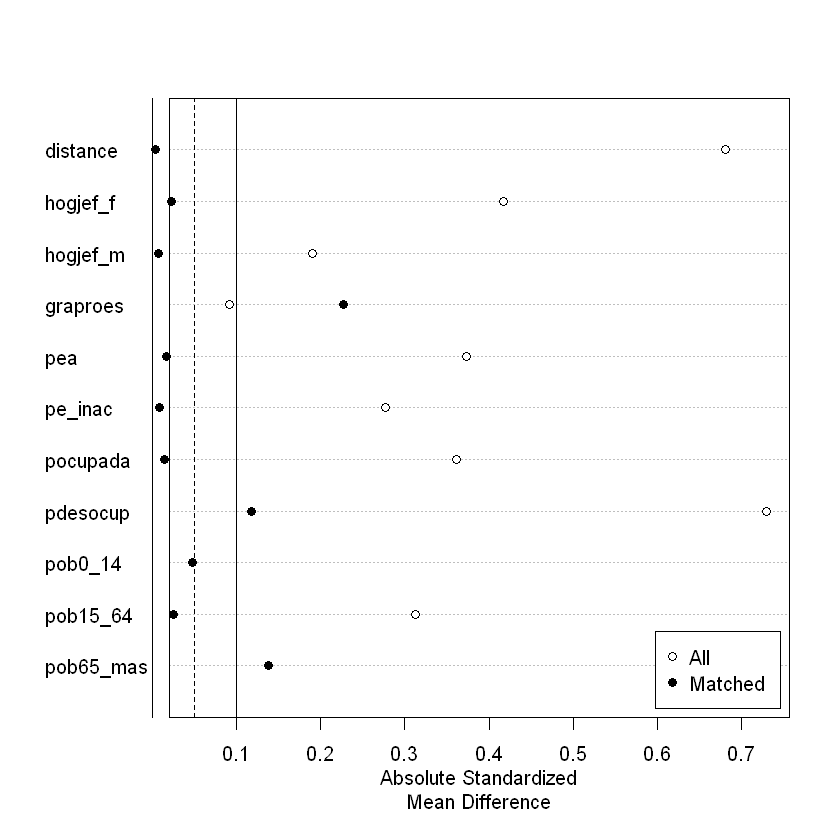

In [14]:
propscorematch(var_modelo = var_modelo, link_model = binomial(link = "logit"))

#### Modelo logit con transformación de variables de población a logaritmos


=== RESULTADOS DEL MODELO LOGIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -4.38289    0.76387  -5.738  9.6e-09
log(ifelse(hogjef_f == 0, 1, hogjef_f))    -0.43403    0.26996  -1.608  0.10789
log(ifelse(hogjef_m == 0, 1, hogjef_m))     0.78198    0.60193   1.299  0.19391
graproes                                   -0.07049    0.12107  -0.582  0.56040
log(ifelse(pea == 0, 1, pea))             -11.46075    6.90339  -1.660  0.09688
log(ifelse(pe_inac == 0, 1, pe_inac))      -1.53754    0.57039  -2.696  0.00703
log(ifelse(pocupada == 0, 1, pocupada))     6.57813    6.56378   1.002  0.31625
log(ifelse(pdesocup == 0, 1, pdesocup))    -0.63946    0.44995  -1.421  0.15526
log(ifelse(pob0_14 == 0, 1, pob0_14))       1.18848    0.49305   2.410  0.01593
log(ifelse(pob15_64 == 0, 1, pob15_64))     4.79161    1.68891   2.83

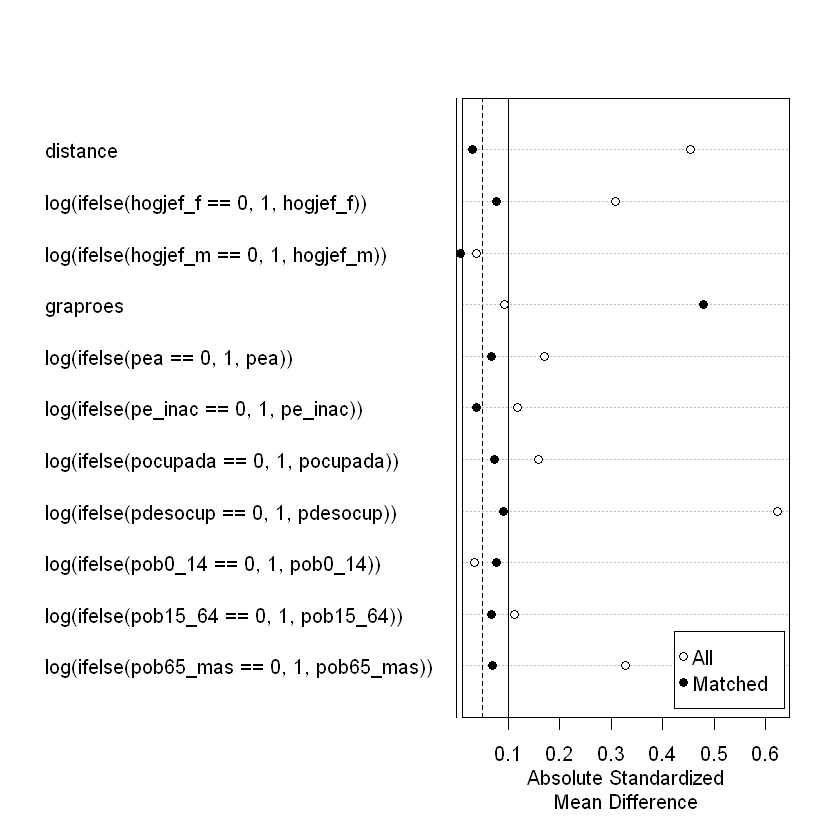

In [15]:
propscorematch(var_modelo = var_modelo2, link_model = binomial(link = "logit"))